In [6]:
# td3_train.py
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random

# 设置随机种子
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# 演员网络
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, action_dim)
        self.max_action = max_action

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        action = torch.tanh(self.fc3(x)) * self.max_action
        return action

# 批评家网络（双 Q 网络）
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        # Q1 网络
        self.fc1 = nn.Linear(state_dim + action_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        # Q2 网络
        self.fc4 = nn.Linear(state_dim + action_dim, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 1)

    def forward(self, state, action):
        sa = torch.cat([state, action], dim=-1)
        # Q1 输出
        q1 = F.relu(self.fc1(sa))
        q1 = F.relu(self.fc2(q1))
        q1 = self.fc3(q1)
        # Q2 输出
        q2 = F.relu(self.fc4(sa))
        q2 = F.relu(self.fc5(q2))
        q2 = self.fc6(q2)
        return q1, q2

    def Q1(self, state, action):
        sa = torch.cat([state, action], dim=-1)
        q1 = F.relu(self.fc1(sa))
        q1 = F.relu(self.fc2(q1))
        q1 = self.fc3(q1)
        return q1

# TD3 算法
class TD3:
    def __init__(self, state_dim, action_dim, max_action, device):
        self.device = device
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=5e-5)

        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-4)

        self.max_action = max_action
        self.memory = deque(maxlen=100000)
        self.batch_size = 256
        self.gamma = 0.99
        self.tau = 0.005
        self.policy_noise = 0.2
        self.noise_clip = 0.5
        self.expl_noise = 0.1
        self.policy_freq = 2
        self.total_it = 0

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self):
        transitions = random.sample(self.memory, self.batch_size)
        states = torch.FloatTensor(np.array([t[0] for t in transitions])).to(self.device)
        actions = torch.FloatTensor(np.array([t[1] for t in transitions])).to(self.device)
        rewards = torch.FloatTensor([t[2] for t in transitions]).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(np.array([t[3] for t in transitions])).to(self.device)
        dones = torch.FloatTensor([t[4] for t in transitions]).unsqueeze(1).to(self.device)
        return states, actions, rewards, next_states, dones

    def update(self):
        self.total_it += 1
        if len(self.memory) < self.batch_size:
            return 0, 0

        states, actions, rewards, next_states, dones = self.sample()

        with torch.no_grad():
            noise = (torch.randn_like(actions) * self.policy_noise).clamp(-self.noise_clip, self.noise_clip)
            next_actions = (self.actor_target(next_states) + noise).clamp(-self.max_action, self.max_action)
            target_Q1, target_Q2 = self.critic_target(next_states, next_actions)
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = rewards + (1 - dones) * self.gamma * target_Q

        current_Q1, current_Q2 = self.critic(states, actions)
        critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 0.5)
        self.critic_optimizer.step()

        actor_loss = 0
        if self.total_it % self.policy_freq == 0:
            actor_loss = -self.critic.Q1(states, self.actor(states)).mean()
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 0.5)
            self.actor_optimizer.step()

            for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
            for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        return actor_loss.item() if isinstance(actor_loss, torch.Tensor) else actor_loss, critic_loss.item()

    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            action = self.actor(state).cpu().numpy().flatten()
        action = (action + np.random.normal(0, self.expl_noise * self.max_action, size=action.shape)).clip(-self.max_action, self.max_action)
        return action

    def save_model(self, actor_path="actor.pth", critic_path="critic.pth"):
        torch.save(self.actor.state_dict(), actor_path)
        torch.save(self.critic.state_dict(), critic_path)

def train_td3():
    env = gym.make("Pendulum-v1")
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    agent = TD3(state_dim, action_dim, max_action, device)
    episodes = 1000
    max_steps = 1000
    train_rewards = []

    for episode in range(episodes):
        state, _ = env.reset()
        episode_reward = 0

        for step in range(max_steps):
            action = agent.select_action(state)
            next_state, reward, done, truncated, _ = env.step(action)
            agent.store_transition(state, action, reward, next_state, done or truncated)
            actor_loss, critic_loss = agent.update()

            state = next_state
            episode_reward += reward

            if done or truncated:
                break

        train_rewards.append(episode_reward)
        # 每 50 回合打印一次
        if (episode + 1) % 50 == 0:
            print(f"Episode {episode + 1}, Train Reward: {episode_reward:.2f}, "
                  f"Actor Loss: {actor_loss:.4f}, Critic Loss: {critic_loss:.4f}")

    # 保存模型和奖励
    agent.save_model()
    np.save("train_rewards.npy", train_rewards)
    env.close()
    print("Training completed. Models and rewards saved.")

if __name__ == "__main__":
    train_td3()

Episode 50, Train Reward: -1199.21, Actor Loss: 122.1423, Critic Loss: 186.8393
Episode 100, Train Reward: -1132.45, Actor Loss: 209.0867, Critic Loss: 554.8056
Episode 150, Train Reward: -1009.86, Actor Loss: 261.0787, Critic Loss: 973.8795
Episode 200, Train Reward: -768.73, Actor Loss: 298.8854, Critic Loss: 1268.5505
Episode 250, Train Reward: -967.95, Actor Loss: 301.8854, Critic Loss: 1237.8118
Episode 300, Train Reward: -805.84, Actor Loss: 306.2177, Critic Loss: 23.9788
Episode 350, Train Reward: -757.37, Actor Loss: 312.1882, Critic Loss: 17.4143
Episode 400, Train Reward: -697.25, Actor Loss: 306.1164, Critic Loss: 15.0080
Episode 450, Train Reward: -747.21, Actor Loss: 301.0018, Critic Loss: 780.0958
Episode 500, Train Reward: -752.80, Actor Loss: 301.7373, Critic Loss: 629.5774
Episode 550, Train Reward: -763.67, Actor Loss: 293.9748, Critic Loss: 1483.3984
Episode 600, Train Reward: -742.69, Actor Loss: 284.4194, Critic Loss: 570.4581
Episode 650, Train Reward: -704.82, Ac

/tmp/ipykernel_14951/500399430.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  actor.load_state_dict(torch.load("actor.pth"))


Episode 1, Eval Reward: -388.19 ± 472.31
Episode 51, Eval Reward: -943.26 ± 444.48
Episode 101, Eval Reward: -73.02 ± 94.55
Episode 151, Eval Reward: -843.70 ± 548.82
Episode 201, Eval Reward: -369.03 ± 487.66
Episode 251, Eval Reward: -364.70 ± 488.56
Episode 301, Eval Reward: -309.67 ± 500.27
Episode 351, Eval Reward: -144.52 ± 88.42
Episode 401, Eval Reward: -581.60 ± 614.28
Episode 451, Eval Reward: -638.79 ± 540.28
Episode 501, Eval Reward: -483.26 ± 403.79
Episode 551, Eval Reward: -777.99 ± 453.24
Episode 601, Eval Reward: -600.93 ± 555.67
Episode 651, Eval Reward: -910.34 ± 510.84
Episode 701, Eval Reward: -621.31 ± 568.12
Episode 751, Eval Reward: -850.23 ± 548.88
Episode 801, Eval Reward: -333.61 ± 480.91
Episode 851, Eval Reward: -564.84 ± 596.10
Episode 901, Eval Reward: -75.79 ± 98.78
Episode 951, Eval Reward: -378.82 ± 456.47


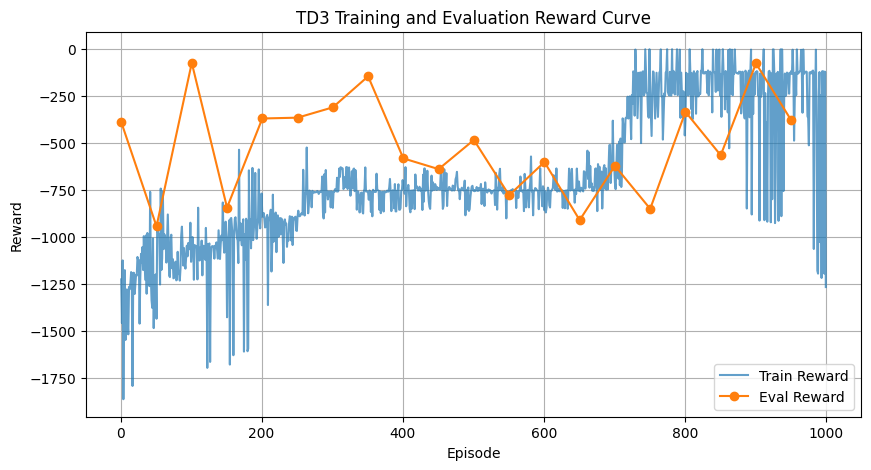

In [7]:
# td3_evaluate.py

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 演员网络
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, action_dim)
        self.max_action = max_action

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        action = torch.tanh(self.fc3(x)) * self.max_action
        return action

def evaluate_policy(actor, env, device, eval_episodes=5):
    eval_rewards = []
    for _ in range(eval_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False
        truncated = False
        while not (done or truncated):
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                action = actor(state_tensor).cpu().numpy().flatten()
            state, reward, done, truncated, _ = env.step(action)
            episode_reward += reward
        eval_rewards.append(episode_reward)
    return np.mean(eval_rewards), np.std(eval_rewards)

def evaluate_td3():
    env = gym.make("Pendulum-v1")
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 加载演员模型
    actor = Actor(state_dim, action_dim, max_action).to(device)
    actor.load_state_dict(torch.load("actor.pth"))
    actor.eval()

    # 加载训练奖励
    train_rewards = np.load("train_rewards.npy")
    episodes = len(train_rewards)

    # 每 50 回合评估一次
    eval_rewards = []
    eval_episodes = []
    eval_interval = 50
    for episode in range(0, episodes, eval_interval):
        mean_reward, std_reward = evaluate_policy(actor, env, device)
        eval_rewards.append(mean_reward)
        eval_episodes.append(episode + 1)
        print(f"Episode {episode + 1}, Eval Reward: {mean_reward:.2f} ± {std_reward:.2f}")

    env.close()

    # 绘制奖励曲线
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, episodes + 1), train_rewards, label="Train Reward", alpha=0.7)
    plt.plot(eval_episodes, eval_rewards, label="Eval Reward", marker='o')
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("TD3 Training and Evaluation Reward Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    evaluate_td3()

In [8]:
# td3_test.py

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# 演员网络
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, action_dim)
        self.max_action = max_action

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        action = torch.tanh(self.fc3(x)) * self.max_action
        return action

def test_td3():
    env = gym.make("Pendulum-v1", render_mode="human")
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 加载演员模型
    actor = Actor(state_dim, action_dim, max_action).to(device)
    actor.load_state_dict(torch.load("actor.pth"))
    actor.eval()

    # 运行 5 次测试回合
    print("Running test episodes with rendering...")
    for i in range(5):
        state, _ = env.reset()
        episode_reward = 0
        done = False
        truncated = False
        step = 0
        max_steps = 1000

        while not (done or truncated):
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                action = actor(state_tensor).cpu().numpy().flatten()
            state, reward, done, truncated, info = env.step(action)
            episode_reward += reward
            env.render()
            step += 1
            if step >= max_steps:
                truncated = True

        # 判断终止原因
        if done:
            reason = "Stopped (likely upright)"  # Pendulum-v1 没有明确静止终止，假定 done 表示接近直立
        elif step >= max_steps:
            reason = "Timeout"
        else:
            reason = "Unknown"

        print(f"Test Episode {i + 1}, Reward: {episode_reward:.2f}, Steps: {step}, Reason: {reason}")

    env.close()

if __name__ == "__main__":
    test_td3()

/tmp/ipykernel_14951/3978549490.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  actor.load_state_dict(torch.load("actor.pth"))


Running test episodes with rendering...
Test Episode 1, Reward: -123.57, Steps: 200, Reason: Unknown
Test Episode 2, Reward: -1315.23, Steps: 200, Reason: Unknown
Test Episode 3, Reward: -260.52, Steps: 200, Reason: Unknown
Test Episode 4, Reward: -1491.60, Steps: 200, Reason: Unknown
Test Episode 5, Reward: -1294.69, Steps: 200, Reason: Unknown
